## 电子商务网站运行A/B测试分析

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

本篇分析是关于电子商务网站运行的 A/B 测试的结果。目标是通过该分析来帮助公司判断是否应该使用新的页面，保留旧的页面，或者是否应该将测试时间延长，并通过回归分析确认转化率是否与国家地区相关。最后给出我个人的建议。

<a id='probability'></a>
#### I - 概率

让我们先导入库。

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#确保每次运行结果相同
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。 

a. 导入数据集，并在这里查看前几行：

In [107]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [108]:
#确定起止时间
df['timestamp'].min()
df['timestamp'].max()

'2017-01-24 13:41:54.460509'

b. 使用下面的单元格来查找数据集中的行数。

In [109]:
df.shape

(294478, 5)

c. 数据集中独立用户的数量。

In [110]:
len(df['user_id'].unique())

290584

290584

d. 用户转化的比例。

In [111]:
converted_ratio=float(df['converted'].sum())/df['user_id'].count()

In [112]:
print(converted_ratio)

0.119659193556


注：由于这里还没有进行数据清理，部分数据存在错配，重复的问题，因此这里求精确数据没有太大意义，只是计算出一个估计值：显示比例大约在0.12左右。

e.  `new_page` 与 `treatment` 不一致的次数。

In [57]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

***3893次***


f. 是否有任何行存在缺失值

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


***无缺失值***

`2.` 处理 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，

a. 现在创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [65]:
df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index,axis=0,inplace=True)

In [66]:
df.dropna(axis=0,how='any',inplace=True)
df.info()
df.to_csv('ab_data_clean.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [3]:
df2=pd.read_csv('ab_data_clean.csv')

In [4]:
# 检查
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`  **df2** 

a.  **df2** 中有多少唯一的 **user_id**

In [5]:
len(df2['user_id'].unique())

290584

***290584个唯一的user_id***

b.  **df2** 中有一个重复的 **user_id** 

In [6]:
df2['user_id'].value_counts().head(1)

773192    2
Name: user_id, dtype: int64

c. 这个重复的  **user_id** 的行信息

In [7]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行。

In [8]:
df2.drop(2862,axis=0,inplace=True)

`4.`  转化率。

a. 单个用户的转化率是


In [9]:
sin_cr=df2['converted'].sum()/float(df2['user_id'].count())
print(sin_cr)

0.119597087245


***单个用户的平均转化率为0.1196***

b. `control` 组中用户的转化率是

In [10]:
con_cr=df2.groupby('group')['converted'].sum().astype(float)[0]/df2.groupby('group')['group'].count()[0]
print(con_cr)

0.1203863045


***control组的用户转化率为0.1204***

c.  `treatment` 组中用户的转化率是


In [11]:
tre_cr=df2.groupby('group')['converted'].sum().astype(float)[1]/df2.groupby('group')['group'].count()[1]
print(tre_cr)

0.118808065515


***treatment组的转化率为0.1188***

d. 用户收到新页面的概率是


In [12]:
rn_p=df2.groupby('landing_page')['landing_page'].count().astype(float)[0]/df2['user_id'].count()
print(rn_p)

0.500061944223


***用户收到新页面的概率是0.5001***


**这里控制组下用户的转化率微微高过处理组下用户的转化率。**

<a id='ab_test'></a>
### II - A/B 测试


`1.` 建立假设



**零假设：新页面的转化率小于或等于旧页面的转化率(P old>=P new)**

**备择假设：新页面的转化率大于旧页面的转化率(P old< P new)**

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是


**0.1196**

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是 <br><br>

**0.1196**

c.  $n_{new}$ 是

**145310**

d.  $n_{old}$

**145274**

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [13]:
new_page_converted=np.random.choice([0,1],size=145310,p=[1-sin_cr,sin_cr])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [14]:
old_page_converted=np.random.choice([0,1],size=145274,p=[1-sin_cr,sin_cr])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [15]:
new_page_converted.mean()-old_page_converted.mean()

0.001271524437922042

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 diffs** 中。

In [16]:
diffs=[]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=145310,p=[1-sin_cr,sin_cr])
    old_page_converted=np.random.choice([0,1],size=145274,p=[1-sin_cr,sin_cr])
    diff=new_page_converted.mean()-old_page_converted.mean()
    diffs.append(diff)
np.array(diffs)
    

array([ -8.07142195e-04,   1.25763627e-03,   4.59602465e-05, ...,
        -1.15864464e-03,  -4.49417889e-04,  -1.57528992e-05])

i. 绘制一个 **diffs** 直方图

(array([   12.,    85.,   488.,  1650.,  3034.,  2810.,  1431.,   409.,
           73.,     8.]),
 array([ -4.77872891e-03,  -3.80757287e-03,  -2.83641682e-03,
         -1.86526078e-03,  -8.94104736e-04,   7.70513080e-05,
          1.04820735e-03,   2.01936340e-03,   2.99051944e-03,
          3.96167548e-03,   4.93283153e-03]),
 <a list of 10 Patch objects>)

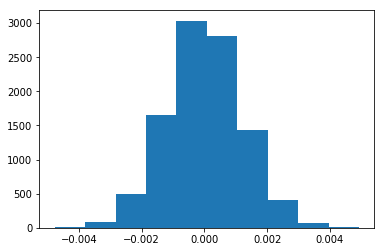

In [17]:
plt.hist(diffs)

**是我所期望的，符合正态分布。**

j.  在**diffs**列表的数值中，大于 **ab_data.csv** 中观察到的实际差值的比例是

In [18]:
(diffs>(tre_cr-con_cr)).mean()

0.91010000000000002

**这个值是假设检验的p值，p值大于0.05，不能拒绝零假设，新旧页面的转化率没有区别。**

k. 使用内置程序 （built-in）来检验结果：

In [19]:
import statsmodels.api as sm

n_old=145274
n_new=145310
convert_old = int(con_cr*n_old)
convert_new = int(tre_cr*n_new)

/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


l. 使用 `stats.proportions_ztest` 来计算检验统计量与 p-值。

In [24]:
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative='smaller')

In [25]:
print(z_score,p_value)

(1.3109241984234394, 0.90505831275902449)


**这里的p值为0.91大于0.05，无法拒绝零假设，即没有显著区别。这里的零假设是p new=p old，与j，k中的检验结果一致，p值略有差别。**

<a id='regression'></a>
### III - 回归分析法

`1.` 执行回归也可获取上述abtest的结果。<br><br>

a. 选择逻辑回归


**逻辑回归**

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。首先为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [94]:
df2['intercept']=1
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0



c. 使用 **statsmodels** 导入回归模型。 实例化该模型，并使用在 **b.** 中创建的2个列来拟合该模型并预测一个用户是否会发生转化。

In [95]:
lr=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 模型摘要如下。

In [96]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        09:18:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值

***p值是0.19***

注：回归模型的零假设是回归系数无效（不显著相关），即系数为零，备择假设是回归系数相关（正相关或负相关），即系数不为零；part 2 中的零假设是新页面的转化率小于或等于旧页面的转化率(P old>=P new)，备则假设是新页面的转化率大于旧页面的转化率(P old>=P new)，这里的回归模型的检验是双尾检验，而part2中的检验是单边检验。因此p值有所不同。

g. 除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加effect 项。导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 

探究国家项对转化是否有影响

In [97]:
df_3=pd.read_csv('countries.csv')
df_3.head()
df3=pd.merge(df2,df_3,how='inner',on='user_id')
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [99]:
df3[['CA','UK','US']]=pd.get_dummies(df3['country'])
lr2=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
results2=lr2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:               2.323e-05
Time:                        09:18:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

***从系数和p值来看，国家对转化率的影响不大，相关性不显著（均大于0.05）***

h. 现在已经查看了国家与页面在转化率上的个体性因素，探究页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。

**页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [100]:
df3['new_CA'] = df3['ab_page'] * df3['CA']
df3['new_UK'] = df3['ab_page'] * df3['UK']
lr3=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK','new_CA','new_UK']])
results3=lr3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        09:18:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

***页面与国家地区间的交互作用并没有对转化率产生重大影响，因为交互项系数接近零，p值不显著。***

<a id='conclusions'></a>
## 总结

**结论：检验结果显示新旧页面的转化率没有显著差别，两个页面对用户的转化作用差别不大。将国家地区因素以及国家于页面的交互作用都予以考虑，依然效果不显著，无明显差别，就结果看，没有太大必要更换页面。观察了持续的时间后，发现持续了22天，可能需要进一步延长测试时间。电子商务的一些特征可能会与季节性的时间因素相关，这一点也需考虑。另外从数据的重复和质量来看（错配，同一用户出现多次），需要进一步完善数据收集的工作。**
